In this Notebook, Machine Learning (ML) models will be performed on Log Returns transformation along with the different scaling techniques. 

The order of ML to be applied will follow: 

- SARIMA: The series presented different seasonal patterns at different frequencies (5, 21, 63 and 126), making the model a good fit. In addition, the model is the extension of the ARIMA, which can capture short term correlation (autocorrelation and moving average). 

- Neural Networks:
non=linear relationships....
- Hybrid Models: 
....


Different models are being applied because each one presents different strenghts, models that can capture linear and non-linear relationships, seasonalities. And ultimately compare the peformance scores to indicate which model would the best fit for the data. 
  
**Note**: Rationale for MLs will be written in the Log_Returns ML Notebook and not in the Seasonal Differencing to avoid repetition.

# IF STARTS TO GET CONFUSING OR TOO SLOW APPLY OTHERS IN DIFFERENT NOTEBOOKS. 

In [2]:
# Importing libraries for the project.
import pandas as pd
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df = pd.read_csv('df_log.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.   

In [4]:
df.head()

,Close,Year
Date,,
2014-01-01,0.000000,2014
2014-01-02,-0.008901,2014
2014-01-03,-0.000333,2014
2014-01-06,-0.002515,2014
2014-01-07,0.006063,2014


In [5]:
# Column Year is going to be dropped, is no longer relevant in the analysis. 
df = df.drop(columns=['Year'])

# Ensures that the index is sorted.
df = df.sort_index()

# Forecasting Models. 

To start, the data will be splited into train and test sets, with the selected ratio of 90%-10%. There are 10 years worth of data, thus the test set will start from 01-01-23 to 31-12-23 and the train would be composed by the data prior to 2023.

**Note**: Stage where different split ratios could be tested depending on the time available. 

In [7]:
# Extracting the total size, based on the length of the series.
total_size = len(df)

# Calculates indices for the 80-10-10 split.
train_size = int(total_size * 0.80) # 80%.
val_size = int(total_size * 0.10) # 10%.
test_size = total_size - train_size - val_size  # The remaining 10%. 

# Performing the splits.
train = df.iloc[:train_size]  # First 80% of the data.
val = df.iloc[train_size:train_size + val_size]  # Next 10% of the data.
test = df.iloc[train_size + val_size:]  # Final 10% of the data.

In [8]:
display(train, val, test)

,Close
Date,
2014-01-01,0.000000
2014-01-02,-0.008901
2014-01-03,-0.000333
2014-01-06,-0.002515
2014-01-07,0.006063
...,...
2021-12-23,0.006204
2021-12-24,0.000000
2021-12-27,0.013744


,Close
Date,
2021-12-30,-0.002994
2021-12-31,-0.002630
2022-01-03,0.006354
2022-01-04,-0.000630
2022-01-05,-0.019583
...,...
2022-12-22,-0.014557
2022-12-23,0.005851
2022-12-26,0.000000


,Close
Date,
2022-12-29,0.017311
2022-12-30,-0.002544
2023-01-02,0.000000
2023-01-03,-0.004009
2023-01-04,0.007511
...,...
2023-12-25,0.000000
2023-12-26,0.004223
2023-12-27,0.001429


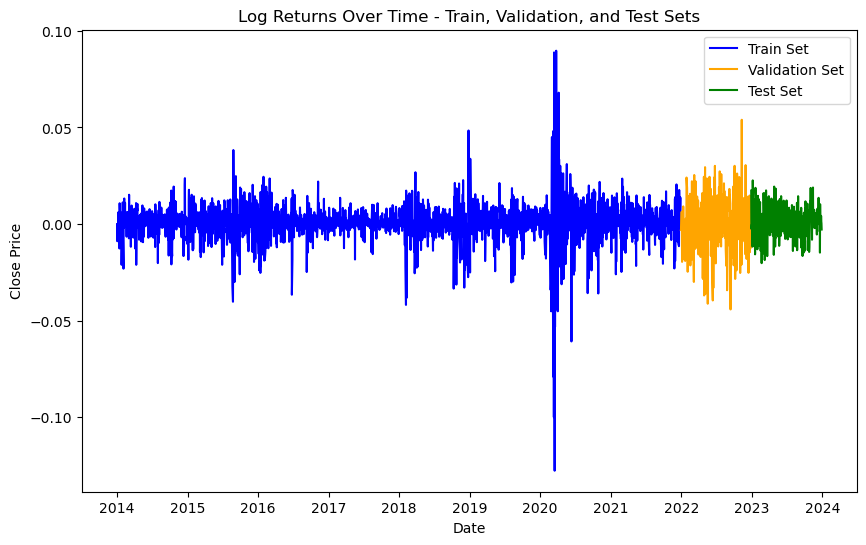

In [9]:
# Creates lineplot indicating the timeframe for each set. 
plt.figure(figsize=(10,6))

# Plot the training set in blue
plt.plot(train.index, train['Close'], label='Train Set', color='blue')

# Plot the validation set in orange
plt.plot(val.index, val['Close'], label='Validation Set', color='orange')

# Plot the test set in green
plt.plot(test.index, test['Close'], label='Test Set', color='green')

# Adding title and labels
plt.title('Log Returns Over Time - Train, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Add a legend to differentiate the sets
plt.legend()

# Display the plot
plt.show()

## SARIMA

The model will be applied in each scaling method to find which one of three perfomes better using SARIMA. 

**BRIEF EXPLANATION OF THE PARAMETERS OF SARIMA**

Non-seasonal (ARIMA) of the model 
- p: is the autoregressive order. 
- d: differencing necessary to make the data stationary. 
- q: moving average order.

Seasonal (SARIMA) model
- P: seasonal autogressive. 
- D: seasonal differencing order.  
- Q: seasonal moving average. 
- m: The frequency, for business days, 5 is a week, 21 is on average a month.

And to find their values, different approaches can be taken. In this project, two techniques will be applied to test different ways and check which one will yield the best order/performance. 



GridSearch was attempted, however it was taking too long to run the code. Also, the, range of p and q were adjusted 4 and 3 but also time consuming.
Thus, instead of reducing the value of p and q even more, a different technique will be applied (Random Search).


## Random search, it takes time after 30 

In [13]:
import statsmodels.api as sm
from sklearn.model_selection import ParameterSampler
import pandas as pd

# Define the parameter space for random search
param_grid = {
    'p': [0, 1, 2, 3],        # Range for p
    'd': [0, 1],              # Range for d (usually 0 or 1)
    'q': [0, 1, 2, 3],        # Range for q
    'P': [0, 1, 2],           # Range for seasonal P
    'D': [0, 1],              # Range for seasonal D (usually 0 or 1)
    'Q': [0, 1, 2],           # Range for seasonal Q
    'm': [5, 21]              # Seasonal period (m = 5 and m = 21)
}

# Number of random combinations to try
n_iter_search = 30

# Generate random parameter combinations
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))


# Function to evaluate SARIMA model and return AIC
def evaluate_sarima(params):
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit the SARIMA model with the current parameters
        model = sm.tsa.statespace.SARIMAX(train['Close'],
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, m),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        result = model.fit(disp=False)

        # Return AIC as the performance metric
        return result.aic
    except:
        # If model fitting fails, return a large AIC value so it is not selected
        return np.inf

# Run random search
best_aic = np.inf
best_params = None

for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    
    # Evaluate the SARIMA model for the current parameter combination
    aic = evaluate_sarima(params)
    
    # Track the best performing parameters and AIC
    if aic < best_aic:
        best_aic = aic
        best_params = params

    print(f"AIC: {aic}")

# Output the best parameters and the best AIC score
print(f"Best parameters: {best_params}")
print(f"Best AIC: {best_aic}")

Testing SARIMA parameters: {'q': 2, 'p': 3, 'm': 5, 'd': 1, 'Q': 2, 'P': 0, 'D': 0}
AIC: -13024.075297411708
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 21, 'd': 1, 'Q': 2, 'P': 0, 'D': 1}
AIC: -12508.14103081406
Testing SARIMA parameters: {'q': 0, 'p': 2, 'm': 5, 'd': 0, 'Q': 0, 'P': 0, 'D': 1}
AIC: -11600.947874390413
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 21, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
AIC: -11067.84276967795
Testing SARIMA parameters: {'q': 3, 'p': 2, 'm': 5, 'd': 0, 'Q': 2, 'P': 0, 'D': 1}
AIC: -12913.738000581401
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 21, 'd': 0, 'Q': 0, 'P': 1, 'D': 0}
AIC: -12910.884619842245
Testing SARIMA parameters: {'q': 1, 'p': 1, 'm': 21, 'd': 1, 'Q': 0, 'P': 0, 'D': 1}
AIC: -11470.570142532873
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 5, 'd': 1, 'Q': 2, 'P': 2, 'D': 0}
AIC: -12846.312888734197
Testing SARIMA parameters: {'q': 3, 'p': 3, 'm': 21, 'd': 0, 'Q': 2, 'P': 1, 'D': 0}
AIC: -12771.423347596508
Testing SARIMA p

In [14]:
# Define a list of possible m values (seasonal periods) to test
m_values = [5, 21]

# Perform automatic search with different seasonal periods (m)
for m in m_values:
    print(f"Testing seasonal period: m = {m}")
    model = pm.auto_arima(train['Close'], 
                          seasonal=True, 
                          m=m,               # Set the seasonal period to be tested
                          start_p=0, start_q=0, 
                          max_p=3, max_q=3, 
                          d=None,       # Differencing order from stationarity tests
                          D=None,       # Seasonal differencing order
                          start_P=0, start_Q=0, 
                          max_P=3, max_Q=3, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          stepwise=True)

    print(f"Best model for m = {m}: {model.summary()}\n")

Testing seasonal period: m = 5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-12990.074, Time=0.27 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-13055.065, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-13043.194, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-12988.305, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=-13057.000, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=-13055.125, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=-13052.552, Time=0.71 sec
 ARIMA(2,0,0)(0,0,0)[5] intercept   : AIC=-13069.347, Time=0.31 sec
 ARIMA(2,0,0)(1,0,0)[5] intercept   : AIC=-13063.402, Time=0.75 sec
 ARIMA(2,0,0)(0,0,1)[5] intercept   : AIC=-13067.200, Time=0.46 sec
 ARIMA(2,0,0)(1,0,1)[5] intercept   : AIC=-13064.722, Time=0.64 sec
 ARIMA(3,0,0)(0,0,0)[5] intercept   : AIC=-13069.452, Time=0.27 sec
 ARIMA(3,0,0)(1,0,0)[5] intercept   : AIC=-13067.336, Time=1.87 sec
 ARIMA(3,0,0)(0,0,1)[5] intercept   : AIC=

**setting m=252 for auto-arima returning memory error**

#### Close_Power_Scaled

In [18]:
# Define a list of possible m values (seasonal periods) to test
m_values = [5, 21]

# Perform automatic search with different seasonal periods (m)
for m in m_values:
    print(f"Testing seasonal period: m = {m}")
    model = pm.auto_arima(train['Close'], 
                          seasonal=True, 
                          m=m,               # Set the seasonal period to be tested
                          start_p=0, start_q=0, 
                          max_p=3, max_q=3, 
                          d=None,       # Differencing order from stationarity tests
                          D=None,       # Seasonal differencing order
                          start_P=0, start_Q=0, 
                          max_P=3, max_Q=3, 
                          trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True,
                          stepwise=True)

    print(f"Best model for m = {m}: {model.summary()}\n")

Testing seasonal period: m = 5
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-12990.074, Time=0.25 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-13055.065, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-13043.194, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-12988.305, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=-13057.000, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=-13055.125, Time=0.32 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=-13052.552, Time=0.73 sec
 ARIMA(2,0,0)(0,0,0)[5] intercept   : AIC=-13069.347, Time=0.30 sec
 ARIMA(2,0,0)(1,0,0)[5] intercept   : AIC=-13063.402, Time=0.75 sec
 ARIMA(2,0,0)(0,0,1)[5] intercept   : AIC=-13067.200, Time=0.45 sec
 ARIMA(2,0,0)(1,0,1)[5] intercept   : AIC=-13064.722, Time=0.63 sec
 ARIMA(3,0,0)(0,0,0)[5] intercept   : AIC=-13069.452, Time=0.27 sec
 ARIMA(3,0,0)(1,0,0)[5] intercept   : AIC=-13067.336, Time=1.95 sec
 ARIMA(3,0,0)(0,0,1)[5] intercept   : AIC=